# Equation of State Curve Compression

In [1]:
import os
import mendeleev
import numpy as np
from matplotlib import pyplot as plt

## Plotting and Utility Functions

In [2]:
def color(z, scale=240):
    k = 2 * np.pi * z / scale
    return (1 + np.asarray([np.sin(k), np.sin(k + 2 * np.pi / 3), np.sin(k + 4 * np.pi / 3)], dtype=float)) / 2


def SMA_smooth(x, y, k=5):
    n = len(x)
    smooth_y = np.zeros(n - 2 * k)
    for i in range(k, n - k):
        neighbors = np.arange(i - k, i + k + 1)
        smooth_y[i - k] = np.mean(y[neighbors])
    return np.array([x[k:n - k], smooth_y]).T


def gaussian_smooth(x, y, k=3):
    n = len(x)
    smooth_y = []
    kernel = np.exp(-np.square(np.arange(-k, k + 1)))
    kernel /= np.sum(kernel)
    for i in range(k, n - k):
        smooth_y.append(kernel @ y[i - k:i + k + 1])
    return np.array([x[k:n - k], smooth_y]).T


def interpolate(data, k):
    index = np.searchsorted(data[:, 0], k)
    dx = data[index, 0] - data[index - 1, 0]
    dy = data[index, 1] - data[index - 1, 1]
    return data[index - 1, 1] + (k - data[index - 1, 0]) * (dy / dx)


def augment(data, k=2, var=1):
    integer_kernel = np.exp(-np.square(np.linspace(-k, k, num=2 * k + 1)) / var)
    half_kernel = np.exp(-np.square(np.linspace(-k - 0.5, k + 0.5, num=2 * (k + 1))) / var)

    n = data.shape[0]
    augmented_data = np.zeros((2 * (n - 2 * k) - 1, data.shape[1]))
    for i in range(k, n - k):
        augmented_data[2 * (i - k)] = np.average(data[i - k:i + k + 1], axis=0, weights=integer_kernel)
        if i != n - k - 1:
            augmented_data[2 * (i - k) + 1] = np.average(data[i - k:i + k + 2], axis=0, weights=half_kernel)
    return augmented_data


def clip_negative(data):
    for i in range(len(data) - 1, -1, -1):
        if data[i, 1] <= 0:
            break
    return data[i + 2:]

In [3]:
AMU = 1.66054e-27
PLANCK = 6.62607004e-34

noble_gases = ['He', 'Ne', 'Ar', 'Kr', 'Xe']
alkaline_metals = ['H', 'Li', 'Cs', 'Fr']
halogens = ['H', 'F', 'Cl', 'I']

# Thomas-Fermi Model Normalization

To gain an intuition of how we should normalize the $x$-axis, we first look at the Thomas-Fermi data, which is more well behaved and will more easily collapse.

In [4]:
TF_elements = []

pressure, element = {}, {}

for file in os.listdir('Pressure Data/Thomas-Fermi Data'):
    elem = file[:file.index('_')]

    if hasattr(mendeleev, elem):
        e = getattr(mendeleev, elem)
    else:
        continue

    tf_data = np.loadtxt(f'Pressure Data/Thomas-Fermi Data/{file}', dtype=float)
    log_tf_data = SMA_smooth(*np.log(tf_data[:11500]).T)

    TF_elements.append(elem)
    element[elem] = e
    pressure[elem] = log_tf_data

TF_elements.sort(key=lambda elem: element[elem].mass)

Throughout this analysis, a key technique is to analyze the logarithmic derivative, i.e. the derivative of a function's logarithm. The motivation for this is that we suspect the underlying form might be $P_{Thomas-Fermi}(E, \rho) = \mathcal{C}_E \cdot \mathcal{P}(f_E(\rho))$ for some constant $\mathcal{C}_E$ that depends on the element, and some transformation $f_E$ on the density $\rho$ that also depends on the element. To remove the constant, we can take the logarithm to convert $\mathcal{C}_E$ into an additional constant $+ \log\mathcal{C}_E$ and take the derivative to remove it. Another interpretation is that scaling a function also scales its derivative, so dividing the derivative $f'$ by the original function $f$ is invariant to scaling and $\frac{1}{f}\partial f = \partial\log f$.

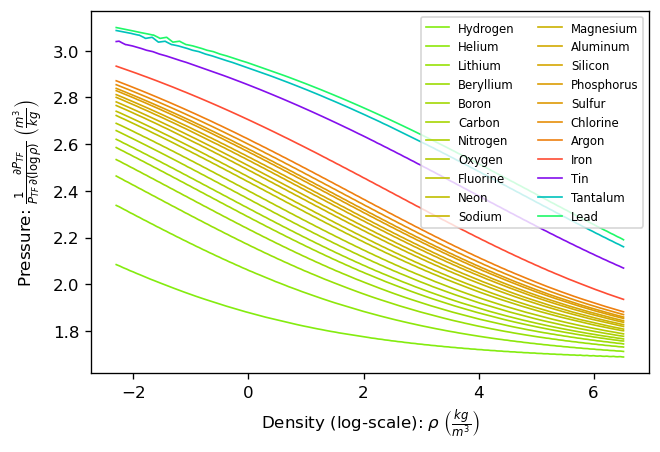

In [5]:
plt.figure(dpi=120)
for elem in TF_elements:
    e, p = element[elem], pressure[elem]

    plt.plot(p[:-1, 0], np.diff(p[:, 1], 1) / np.diff(p[:, 0], 1), color=color(e.mass), linewidth=1, label=e.name)

plt.xlabel(r'Density (log-scale): $\rho$ $\left(\frac{kg}{m^3}\right)$')
plt.ylabel(r'Pressure: $\frac{1}{P_{TF}} \frac{\partial P_{TF}}{\partial (\log\rho)}$ $\left(\frac{m^3}{kg}\right)$')
plt.legend(ncol=2, fontsize=7)
plt.show()

The curves above seem reasonably susceptible to collapse with an $x$-axis shift. Sure enough, normalizing the density by dividing by the atomic mass $m$ and the atomic number $z$, i.e. $\rho / (m \cdot z)$ collapses the log-derivative cleanly. Keep in mind that although the atomic number is unit-less, its meaning still corresponds to charge, so it has pseudo-units of Coulombs, denoted $C'$.

The actual motivation for why we divide by $m \cdot z$ specifically will be shown later. We will see that there is strong reason to divide by the mass when analyzing the hydrogen isotopes which do not differ in atomic number, and $z$ is used to recover the rest of the difference. Even though atomic number and atomic mass have a somewhat linear relationship, the relation is not precise enough for any other combinations to yield nearly as clean a collapse.

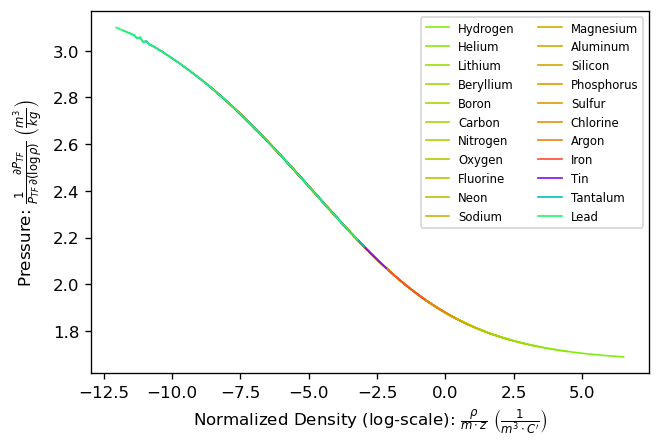

In [6]:
plt.figure(dpi=120)
for elem in TF_elements:
    e, p = element[elem], pressure[elem]

    x = p[:, 0] - np.log(e.atomic_number * e.mass)
    y = p[:, 1]
    plt.plot(x[:-1], np.diff(y) / np.diff(x), color=color(e.mass), linewidth=1, label=e.name)

plt.xlabel(r"Normalized Density (log-scale): $\frac{\rho}{m \cdot z}$ $\left(\frac{1}{m^3 \cdot C'}\right)$")
plt.ylabel(r'Pressure: $\frac{1}{P_{TF}} \frac{\partial P_{TF}}{\partial (\log\rho)}$ $\left(\frac{m^3}{kg}\right)$')
plt.legend(ncol=2, fontsize=7)
plt.show()

Therefore, we have the equation $$\begin{align*}
                    & \frac{1}{P_{Thomas-Fermi}} \frac{\partial P_{Thomas-Fermi}(E, \rho)}{\partial (\log\rho)} = \mathcal{P}^*(\log\rho - \log(m_E \cdot z_E))   \\
    \Rightarrow\    & P_{Thomas-Fermi}(E, \rho) = \mathcal{C}_E \cdot \mathcal{P}^*\left(\frac{\rho}{m_E \cdot z_E}\right)
\end{align*}$$ for some function $\mathcal{P}^*$ and constant $\mathcal{C}_E$ that is dependent on the element. It can be seen by trial and error, and visual inspection that $\mathcal{C}_E \propto z_E^{10 / 3}$ across all elements.

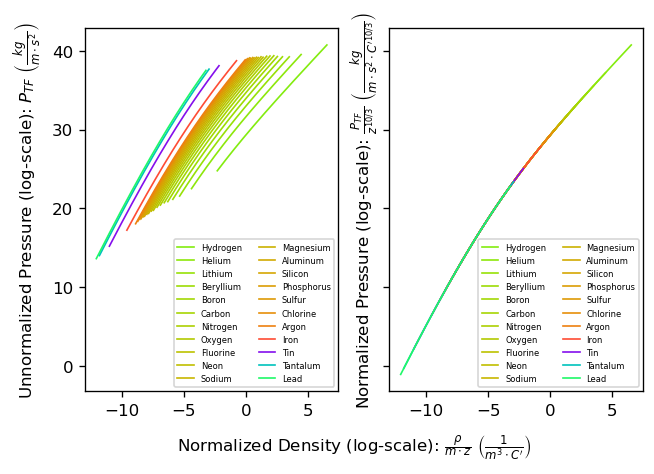

In [7]:
fig, (unnormalized, normalized) = plt.subplots(1, 2, sharey=True)
fig.dpi = 120

normalized_TF_dataset = []
for elem in TF_elements:
    e, p = element[elem], pressure[elem]

    x = p[:, 0] - np.log(e.atomic_number * e.mass)
    unnormalized_y = p[:, 1]
    normalized_y = unnormalized_y - np.log(e.atomic_number) * 10 / 3

    unnormalized.plot(x, unnormalized_y, color=color(e.mass), linewidth=1, label=e.name)
    normalized.plot(x, normalized_y, color=color(e.mass), linewidth=1, label=e.name)

    normalized_TF_dataset.extend(np.array([x, normalized_y]).T)

normalized_TF_dataset.sort(key=lambda p: p[0])
normalized_TF_dataset = SMA_smooth(*np.array(normalized_TF_dataset).T)

fig.text(0.5, 0, r"Normalized Density (log-scale): $\frac{\rho}{m \cdot z}$ $\left(\frac{1}{m^3 \cdot C'}\right)$", ha='center')

unnormalized.set_ylabel(r'Unnormalized Pressure (log-scale): $P_{TF}$ $\left(\frac{kg}{m \cdot s^2}\right)$')
unnormalized.legend(ncol=2, fontsize=5)

normalized.set_ylabel(r"Normalized Pressure (log-scale): $\frac{P_{TF}}{z^{10 / 3}}$ $\left(\frac{kg}{m \cdot s^2 \cdot C'^{10 / 3}}\right)$")
normalized.legend(ncol=2, fontsize=5)

plt.show()

Our final collapsed form for the Thomas-Fermi dataset is then $$
    P_{Thomas-Fermi}(E, \rho) = z_E^{10 / 3} \cdot \mathcal{P^*}\left(\frac{\rho}{m_E \cdot z_E}\right)
$$ for some function $\mathcal{P^*}$ that is independent of the element.

In [8]:
def p_star(k):
    index = np.searchsorted(normalized_TF_dataset[:, 0], k)
    dx = normalized_TF_dataset[index, 0] - normalized_TF_dataset[index - 1, 0]
    dy = normalized_TF_dataset[index, 1] - normalized_TF_dataset[index - 1, 1]
    return normalized_TF_dataset[index - 1, 1] + (k - normalized_TF_dataset[index - 1, 0]) * (dy / dx)

# Purgatorio Model Normalization

In [9]:
orbitals = [
    None, (1, 's'), (2, 's'), (2, 'p'), (3, 's'), (3, 'p'), (4, 's'), (3, 'd'), (4, 'p'), (5, 's'), (4, 'd'), (5, 'p'), (6, 's'), (4, 'f'), (5, 'd'), (6, 'p'), (7, 's')
]

In [10]:
purg_elements = []
orbital, element, pressure = {}, {}, {}

for file in os.listdir('Pressure Data/Purgatorio Data'):
    elem = file[:file.index('.')]
    e = None
    if elem == 'D':
        e = mendeleev.H.isotopes[1]
        e.vdw_radius = 50.0
        e.ec = mendeleev.H.ec
        e.atomic_radius_rahm = mendeleev.H.atomic_radius_rahm
        e.covalent_radius_cordero = mendeleev.H.covalent_radius_cordero
        e.name = 'Deuterium'
        e.symbol = 'D'
    elif elem == 'T':
        e = mendeleev.H.isotopes[2]
        e.vdw_radius = 40.0
        e.mass = 3.016
        e.ec = mendeleev.H.ec
        e.atomic_radius_rahm = mendeleev.H.atomic_radius_rahm
        e.covalent_radius_cordero = mendeleev.H.covalent_radius_cordero
        e.name = 'Tritium'
        e.symbol = 'T'
    elif hasattr(mendeleev, elem):
        e = getattr(mendeleev, elem)
        # if e.atomic_radius is None:
        #     continue
        # e.atomic_radius = float(e.atomic_radius)
    else:
        continue
    orb = orbitals[len(e.ec._conf)]
    if orb in orbital:
        orbital[orb].append(elem)
    else:
        orbital[orb] = [elem]
    element[elem] = e

    purg_data = clip_negative(np.loadtxt(f'Pressure Data/Purgatorio Data/{file}', dtype=float))
    log_purg_data = SMA_smooth(*np.log(purg_data, dtype=float).T)
    if np.mean(np.diff(log_purg_data[:, 0])) > 0.1:
        log_purg_data = augment(log_purg_data)
    # log_purg_data = SMA_smooth(*np.log(purg_data, dtype=float).T)

    # bulk_data = np.loadtxt(f'Elements/{element_name}/Bulk_Test_{element_name}.dat')
    # bulk_prime_data = np.loadtxt(f'Elements/{element_name}/BulkPrime_Test_{element_name}.dat')

    purg_elements.append(elem)
    element[elem] = e
    pressure[elem] = log_purg_data

for elements in orbital.values():
    elements.sort(key=lambda elem: element[elem].mass)

purg_elements.sort(key=lambda elem: element[elem].mass)

First, we take a look at the three isotopes Hydrogen, Deuterium, and Tritium. Note that they appear to be shifted versions of each other, with the heavier isotopes occurring to the right. Furthermore, the $x$-axis is density, which motivates dividing by atomic mass.

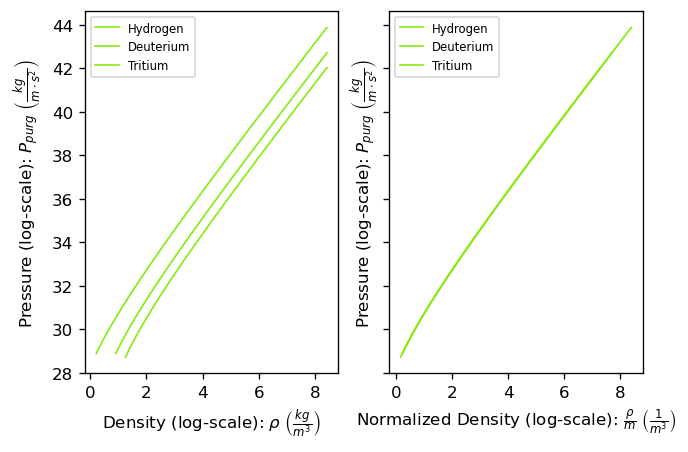

In [11]:
fig, (unnormalized, normalized) = plt.subplots(1, 2, sharey=True)
fig.dpi = 120
for elem in purg_elements[:3]:
    e, p = element[elem], pressure[elem]

    unnormalized.plot(*p.T, color=color(e.mass), linewidth=1, label=e.name)
    normalized.plot(p[:, 0] - np.log(e.mass), p[:, 1], color=color(e.mass), linewidth=1, label=e.name)

unnormalized.set_xlabel(r'Density (log-scale): $\rho$ $\left(\frac{kg}{m^3}\right)$')
unnormalized.set_ylabel(r'Pressure (log-scale): $P_{purg}$ $\left(\frac{kg}{m \cdot s^2}\right)$')
unnormalized.legend(fontsize=7)

normalized.set_xlabel(r'Normalized Density (log-scale): $\frac{\rho}{m}$ $\left(\frac{1}{m^3}\right)$')
normalized.set_ylabel(r'Pressure (log-scale): $P_{purg}$ $\left(\frac{kg}{m \cdot s^2}\right)$')
normalized.legend(fontsize=7)

plt.show()

Note that the plots above are not of the logarithmic derivative, but of pressure itself. However, we have successfully collapsed the pressure curve with mass alone, and since Hydrogen, Deuterium, and Tritium do not differ by atomic number, this strongly suggests there is nothing else to be done with atomic mass, which is the motivation for the Thomas-Fermi normalization above.

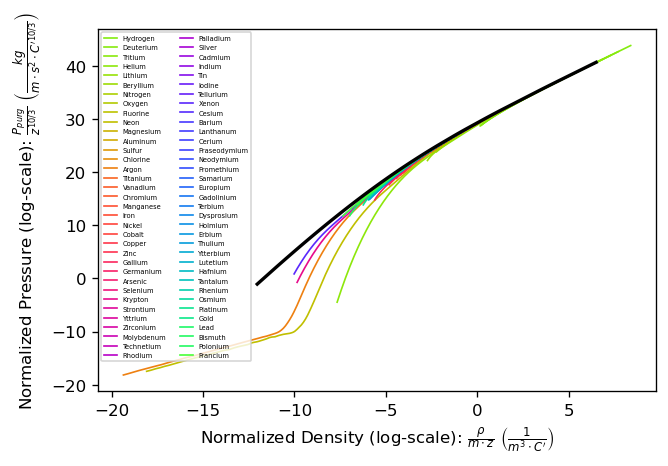

In [12]:
plt.figure(dpi=120)
for elem in purg_elements:
    e, p = element[elem], pressure[elem]

    plt.plot(p[:, 0] - np.log(e.atomic_number * e.mass), p[:, 1] - np.log(e.atomic_number) * 10 / 3, color=color(e.mass), linewidth=1, label=e.name)

plt.plot(*normalized_TF_dataset.T, color='black', linewidth=2)

plt.xlabel(r"Normalized Density (log-scale): $\frac{\rho}{m \cdot z}$ $\left(\frac{1}{m^3 \cdot C'}\right)$")
plt.ylabel(r"Normalized Pressure (log-scale): $\frac{P_{purg}}{z^{10 / 3}}$ $\left(\frac{kg}{m \cdot s^2 \cdot C'^{10 / 3}}\right)$")

plt.legend(ncol=2, fontsize=4)
plt.show()

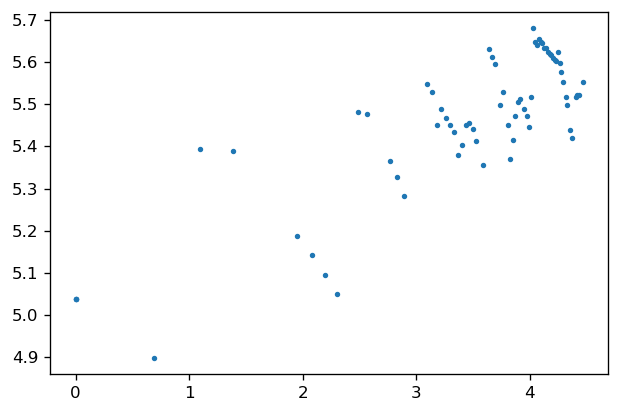

In [13]:
plt.figure(dpi=120)
plt.scatter(*np.log(np.array([[e.atomic_number, e.atomic_radius_rahm] for e in element.values()], dtype=float)).T, s=5)
plt.show()

# Residual Pressure Analysis

The white line above is a plot of the collapsed Thomas-Fermi data. As seen, the Purgatorio data is much less susceptible to collapse that of Thomas-Fermi. The first idea that comes to mind is normalizing by the Thomas-Fermi data itself, i.e. $P_{Purgatorio} / P_{Thomas-Fermi}$, which is equivalent to subtracting on the log-scale. This will help magnify the deviations that still remain and allow us to analyze them more closely. For ease of analysis, we will analyze $\log\left(\frac{P_{Thomas-Fermi}}{P_{Purgatorio}}\right)$ since positive values are open to more possibilities.

One slight problem is that even the total combined Thomas-Fermi data does not span a sufficiently large domain, so we will be required to clip some of the data in order to perform the normalization.

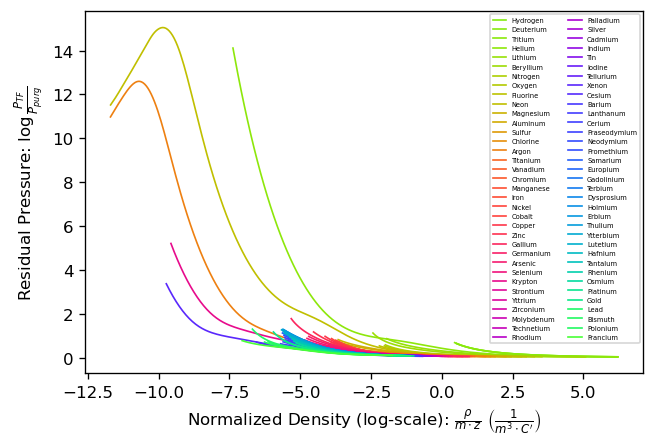

In [14]:
plt.figure(dpi=120)

residual = {}
for elem in purg_elements:
    e, p = element[elem], pressure[elem]

    x = p[:, 0] - np.log(e.atomic_number * e.mass)

    lo, hi = np.searchsorted(x, [normalized_TF_dataset[0, 0], normalized_TF_dataset[-1, 0]])
    x = p[lo:hi, 0] - np.log(e.atomic_number * e.mass)
    log_y = np.log(p_star(x) - (p[lo:hi, 1] - np.log(e.atomic_number) * 10 / 3))
    # y = np.log(1 - np.exp((p[lo:hi, 1] - np.log(e.atomic_number) * 10 / 3) - p_star(x)))
    # y = np.log(np.exp(p_star(x) - (p[lo:hi, 1] - np.log(e.atomic_number) * 10 / 3)) - 1)

    x, log_y = SMA_smooth(x, log_y).T
    y = np.exp(log_y)

    residual[elem] = np.array([x + np.log(e.atomic_number * e.mass), y]).T

    plt.plot(x, y, color=color(e.mass), linewidth=1, label=e.name)

plt.xlabel(r"Normalized Density (log-scale): $\frac{\rho}{m \cdot z}$ $\left(\frac{1}{m^3 \cdot C'}\right)$")
plt.ylabel(r"Residual Pressure: $\log \frac{P_{TF}}{P_{purg}}$")

plt.legend(ncol=2, fontsize=4)

plt.show()

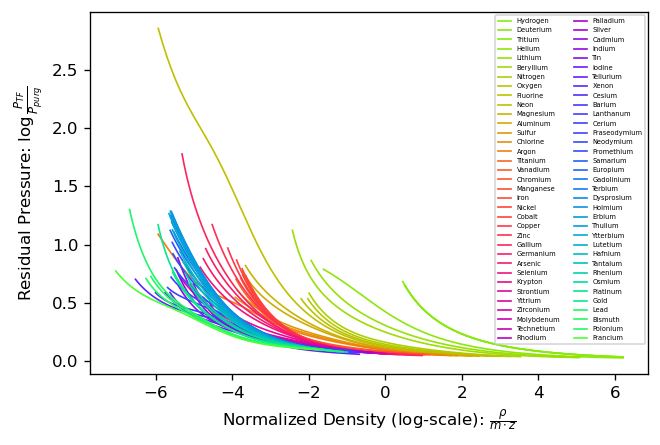

In [15]:
plt.figure(dpi=120)

for elem in purg_elements:
    e, r = element[elem], residual[elem]

    if e.symbol in noble_gases:
        plt.plot(r[100:, 0] - np.log(e.mass * e.atomic_number), r[100:, 1], color=color(e.mass), linewidth=1, label=e.name)
    else:
        plt.plot(r[:, 0] - np.log(e.mass * e.atomic_number), r[:, 1], color=color(e.mass), linewidth=1, label=e.name)

plt.xlabel(r"Normalized Density (log-scale): $\frac{\rho}{m \cdot z}$")
plt.ylabel(r"Residual Pressure: $\log \frac{P_{TF}}{P_{purg}}$")

plt.legend(ncol=2, fontsize=4)

plt.show()

The two plots above are the same, but for better visualization, the second one omits a portion of the left side data for noble gases which allows us to look closer at the "exponential decay" feature of all the elements.

Visually we can see that many of the residual plots look somewhat similar, and not many have notable features or sufficient data we can capitalize on. However, the ones that do so happen to be the noble gases, and we will see if we can use this to our advantage.

## Noble Gases

The key thing to note here is that all curves have similar shape, but it is clear that the ratio of $P_{Purgatorio}$ to $P_{Thomas-Fermi}$ must go to $1$ at infinity and therefore, the relative "sizes" of the curves are due to scaling of some sort and not simply a $y$-axis shift. Because it is the logs that exhibit this homothetic property and not the original function, we must place more emphasis on the $y$-axis being unitless. Furthermore, if we wish to scale the $x$-axis in some nontrivial way, e.g. $e^{\mathcal{C}\log(\rho / (m \cdot z))} = (\rho / (m \cdot z))^\mathcal{C}$ for varying values of $\mathcal{C}$, then we must make that our $x$-axis is properly nondimensionalized, or else we will violate homogeneity. We have seen from the Hydrogen isotopes that $\rho / m$ is necessary.

Even though the plots look feasibly collapsible, there is still not much to work with. All of them seem to have "potentially" the same shape, but we can not do anything with only appearing so, and only two elements Neon and Argon have physical peaks we can analyze. To take on the task of squeezing water from stone take note of the "elbows" that seem to appear near the bottom of the decline. To concretize this idea of "the elbow", we take a look at the curvature of the plots with respect to $x$ and not the conventional arc-length $s$.

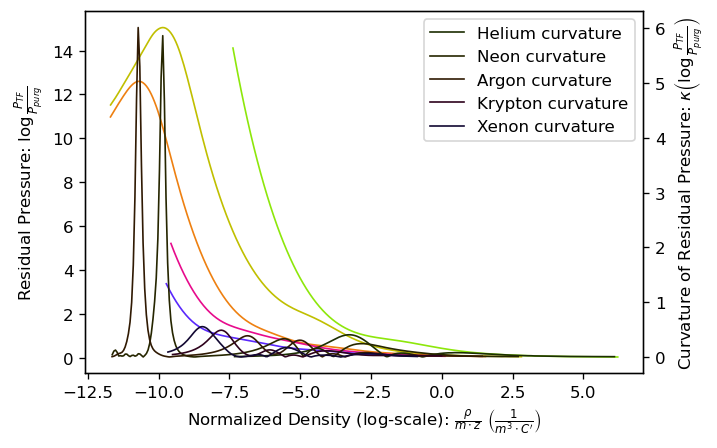

In [16]:
fig, residual_plt = plt.subplots()
curvature_plt = residual_plt.twinx()
fig.dpi = 120

curve_max = {}
curvature = {}
for elem in noble_gases:
    e, r = element[elem], residual[elem]

    x = r[:, 0] - np.log(e.mass * e.atomic_number)
    y = r[:, 1]

    dV = np.diff(r.T, axis=1)
    dV = (dV[:, :-1] + dV[:, 1:]) / 2
    dS = np.linalg.norm(dV, axis=0)
    T = dV / dS
    dT = np.diff(T, axis=1)
    c = np.linalg.norm(dT, axis=0) / dS[:-1]

    curvature[elem] = np.array([r[1:-2, 0], c]).T
    # curvature_list.append((e, np.array([r[1:-1, 0], curvature]).T))

    lo, hi = np.searchsorted(x, [-8.75, -2.5])
    curve_max[elem] = x[lo + np.argmax(c[lo:hi]) + 1]

    residual_plt.plot(x, y, color=color(e.mass), linewidth=1, label=e.name)
    curvature_plt.plot(x[1:-2], c, color=0.2 * color(e.mass), linewidth=1, label=e.name + ' curvature')

residual_plt.set_xlabel(r"Normalized Density (log-scale): $\frac{\rho}{m \cdot z}$ $\left(\frac{1}{m^3 \cdot C'}\right)$")
residual_plt.set_ylabel(r"Residual Pressure: $\log \frac{P_{TF}}{P_{purg}}$")
curvature_plt.set_ylabel(r"Curvature of Residual Pressure: $\kappa\left(\log \frac{P_{TF}}{P_{purg}}\right)$")

curvature_plt.legend()
plt.show()

In [17]:
print([curve_max[elem] for elem in noble_gases])

[-3.2889488763689885, -5.5950853945320835, -6.865773519204294, -7.781669772946172, -8.463463067629252]


As expected, the plot of curvature displays a small peak that is extractable across all elements in the range $[-9, -2]$, although that of Helium seems to deviate a bit, so we will still extract the position of the peak but will keep in mind that it might not be as useful.

Now, suppose we by assume a shift of $3$ times the log of some distance metric such as atomic radius. This will eliminate the inverse volume units to help non-dimensionalize the $x$-axis. The definition of atomic radius adopted is "the average distance from the nucleus to where the electron density falls below $0.001$ electrons per $\text{bohr}^3$." (Rahm et al.)

Slope without Helium: -0.9955377899556241
Slope with Helium: -1.0680350403983958


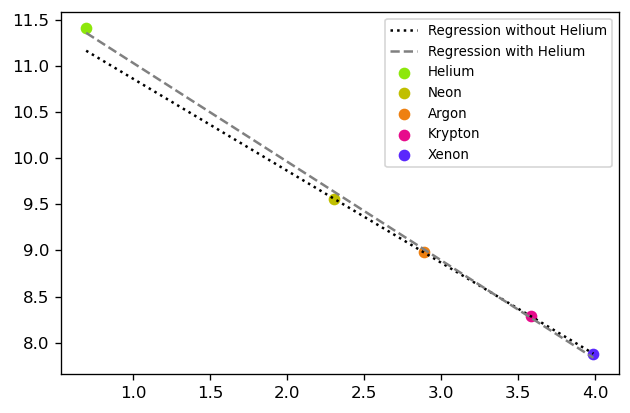

In [18]:
plt.figure(dpi=120)

C = np.array([[np.log(element[elem].atomic_number), curve_max[elem] + 3 * np.log(element[elem].atomic_radius_rahm)] for elem in noble_gases])

X = np.array([C[1:, 0], np.ones(len(C) - 1)]).T
w, b = np.linalg.inv(X.T @ X) @ X.T @ C[1:, 1]

Xp = np.array([C[:, 0], np.ones(len(C))]).T
wp, bp = np.linalg.inv(Xp.T @ Xp) @ Xp.T @ C[:, 1]

for elem in noble_gases:
    e, m = element[elem], curve_max[elem]

    plt.scatter(np.log(e.atomic_number), m + 3 * np.log(e.atomic_radius_rahm), color=color(e.mass), label=e.name)

plt.plot(np.linspace(C[0, 0], C[-1, 0], num=2), w * np.linspace(C[0, 0], C[-1, 0], num=2) + b, color='black', linestyle='dotted', label='Regression without Helium')
plt.plot(np.linspace(C[0, 0], C[-1, 0], num=2), wp * np.linspace(C[0, 0], C[-1, 0], num=2) + bp, color='gray', linestyle='dashed', label='Regression with Helium')

print(f'Slope without Helium: {w}')
print(f'Slope with Helium: {wp}')

plt.legend(fontsize=8)
plt.show()

Above, we can see that the slope of the line is almost precisely equal to $-1$ when we exclude Helium and still close to $-1$ when we include Helium. This suggests that a new normalization might forego the original division by atomic number, and might simply be $(\rho \cdot r_E^3) / m_E$ which is conveniently and intuitively unitless.

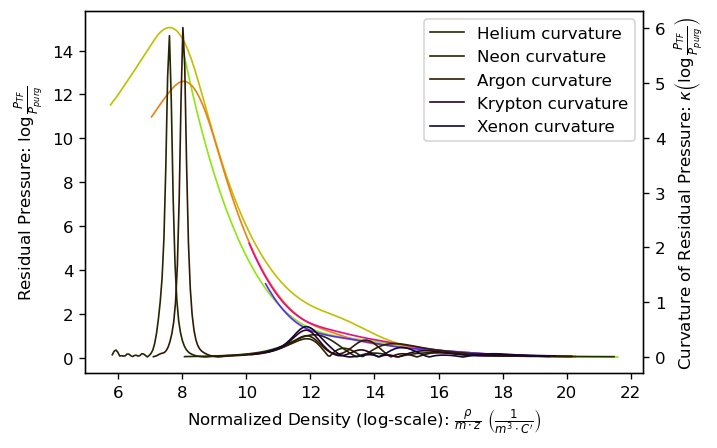

In [19]:
fig, residual_plt = plt.subplots()
curvature_plt = residual_plt.twinx()
fig.dpi = 120

for elem in noble_gases:
    e, r, c = element[elem], residual[elem], curvature[elem]

    x = r[:, 0] + 3 * np.log(e.atomic_radius_rahm) - np.log(e.mass)

    residual_plt.plot(x, r[:, 1], color=color(e.mass), linewidth=1, label=e.name)
    curvature_plt.plot(x[1:-2], c[:, 1], color=0.2 * color(e.mass), linewidth=1, label=e.name + ' curvature')

residual_plt.set_xlabel(r"Normalized Density (log-scale): $\frac{\rho}{m \cdot z}$ $\left(\frac{1}{m^3 \cdot C'}\right)$")
residual_plt.set_ylabel(r"Residual Pressure: $\log \frac{P_{TF}}{P_{purg}}$")
curvature_plt.set_ylabel(r"Curvature of Residual Pressure: $\kappa\left(\log \frac{P_{TF}}{P_{purg}}\right)$")

curvature_plt.legend()
plt.show()

As seen above, the starts of the inclines in the plots above are much better aligned. The alignment of the very low density data of Helium, Neon, and Argon is still questionable, however, the alignment of the collection of elements as a whole is much improved.

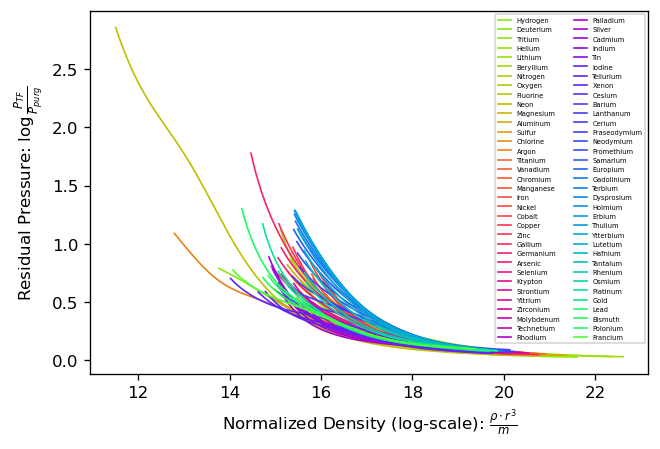

In [20]:
plt.figure(dpi=120)

for elem in purg_elements:
    e, r = element[elem], residual[elem]

    if e.symbol in noble_gases:
        plt.plot(r[100:, 0] + 3 * np.log(e.atomic_radius_rahm) - np.log(e.mass), r[100:, 1], color=color(e.mass), linewidth=1, label=e.name)
    else:
        plt.plot(r[:, 0] + 3 * np.log(e.atomic_radius_rahm) - np.log(e.mass), r[:, 1], color=color(e.mass), linewidth=1, label=e.name)

plt.xlabel(r"Normalized Density (log-scale): $\frac{\rho \cdot r^3}{m}$")
plt.ylabel(r"Residual Pressure: $\log \frac{P_{TF}}{P_{purg}}$")

plt.legend(ncol=2, fontsize=4)

plt.show()

Comparing the above plot with the previous normalization of $\rho / (m \cdot z)$, the "exponential decays" across all the elements seem to be much better aligned than previously. (Once again for better visualization of details, left side data of noble gases are omitted from the plot)

## Orbital Analysis (4p)

Now, we take a look at individual orbitals to see if we can extract further information on how we should normalize. Look at the 3d orbital and see that the plots seem to be concurrent at a single point, and their trajectories somewhat resemble exponential decay. This concurrency point may be useful for constructing inter-orbital relations, because we can have a "prototype" that represents the orbital as a whole. The exponential-like model suggests the form $$
    \log \frac{P_{Thomas-Fermi}(E, \rho)}{P_{Purgatorio}(E, \rho)} = \mathcal{C} \cdot e^{\mathcal{C}_E f\left(\frac{\rho}{m_E \cdot z_E}\right)}
$$ where $\mathcal{C}$ is some constant and $f$ is some function independent of the element, and $\mathcal{C}$ is some constant that depends on the element.

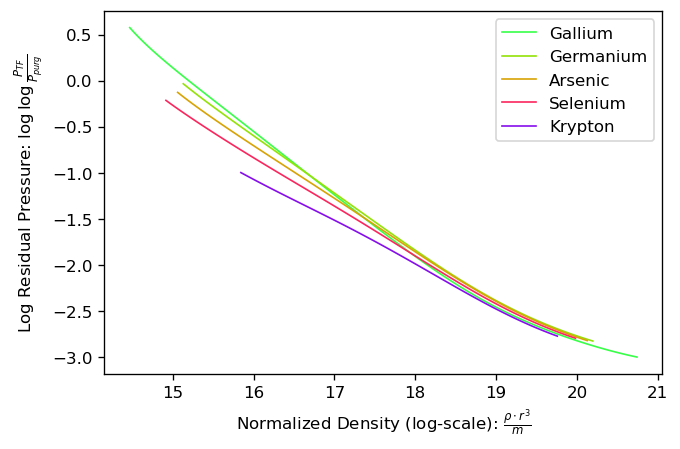

In [21]:
plt.figure(dpi=120)

for elem in orbital[(4, 'p')]:
    e, r = element[elem], residual[elem]

    x = r[:, 0] + 3 * np.log(e.atomic_radius_rahm) - np.log(e.mass)
    y = r[:, 1]

    if elem in noble_gases:
        plt.plot(x[100:], np.log(y[100:]), color=color(e.mass, scale=24), linewidth=1, label=e.name)
    else:
        plt.plot(x, np.log(y), color=color(e.mass, scale=24), linewidth=1, label=e.name)

plt.xlabel(r"Normalized Density (log-scale): $\frac{\rho \cdot r^3}{m}$")
plt.ylabel(r"Log Residual Pressure: $\log\log \frac{P_{TF}}{P_{purg}}$")

plt.legend()
plt.show()

{'Kr': 0, 'Ga': 1.0294449605808929, 'Ge': 0.5969280574675011, 'As': 0.43644351258297576, 'Se': 0.2935740890277785}


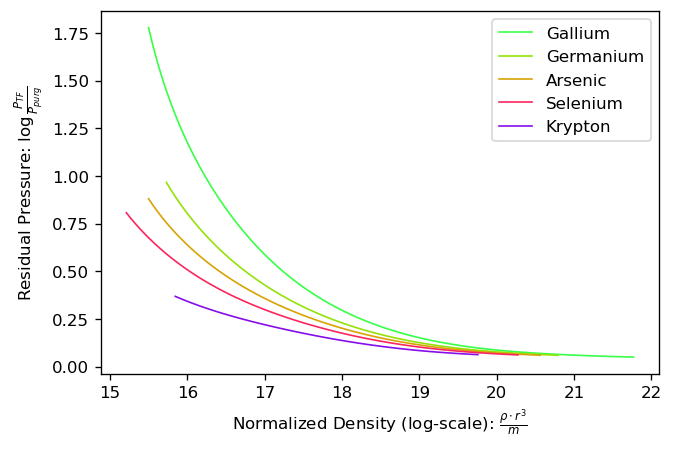

In [22]:
plt.figure(dpi=120)
segment_length = 70

e_Kr, r_Kr = element['Kr'], residual['Kr']
s_Kr = np.log(r_Kr[-segment_length:, 1])
s_Kr -= np.mean(s_Kr)
x_Kr_max = r_Kr[-1, 0] + 3 * np.log(e_Kr.atomic_radius_rahm) - np.log(e_Kr.mass)

displacement = {'Kr': 0}
for elem in orbital[(4, 'p')][:-1]:
    e, r = element[elem], residual[elem]

    x = r[:, 0] + 3 * np.log(e.atomic_radius_rahm) - np.log(e.mass)
    y = r[:, 1]

    max_corr, max_index, max_coeff = -np.inf, None, None
    for i in range(segment_length, len(x)):
        s = np.log(r[i - segment_length:i, 1])
        s -= np.mean(s)

        corr = np.corrcoef(s_Kr, s)[0, 1]
        if corr > max_corr:
            max_corr, max_index = corr, i
    d = x_Kr_max - x[max_index]
    displacement[elem] = d
print(displacement)

for elem in orbital[(4, 'p')]:
    e, r, d = element[elem], residual[elem], displacement[elem]

    x = r[:, 0] + 3 * np.log(e.atomic_radius_rahm) - np.log(e.mass)
    y = r[:, 1]

    if elem in noble_gases:
        plt.plot(x[100:] + d, y[100:], color=color(e.mass, scale=24), linewidth=1, label=e.name)
    else:
        plt.plot(x + d, y, color=color(e.mass, scale=24), linewidth=1, label=e.name)

plt.xlabel(r"Normalized Density (log-scale): $\frac{\rho \cdot r^3}{m}$")
plt.ylabel(r"Residual Pressure: $\log \frac{P_{TF}}{P_{purg}}$")

plt.legend()
plt.show()

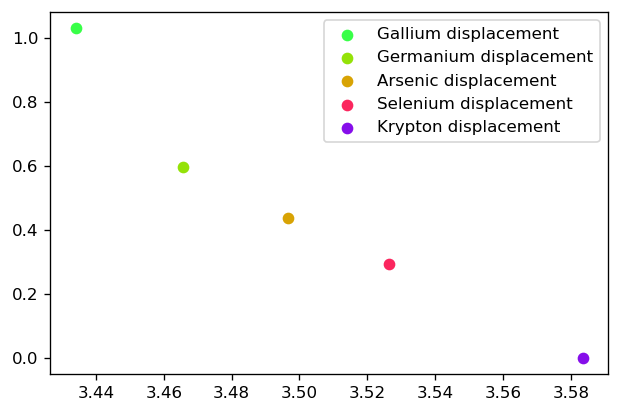

In [23]:
plt.figure(dpi=120)

for elem in orbital[(4, 'p')]:
    e, d = element[elem], displacement[elem]

    plt.scatter(np.log(e.atomic_number), d, color=color(e.mass, scale=24), label=e.name + ' displacement')

plt.legend()
plt.show()

## Orbital Analysis (3p)

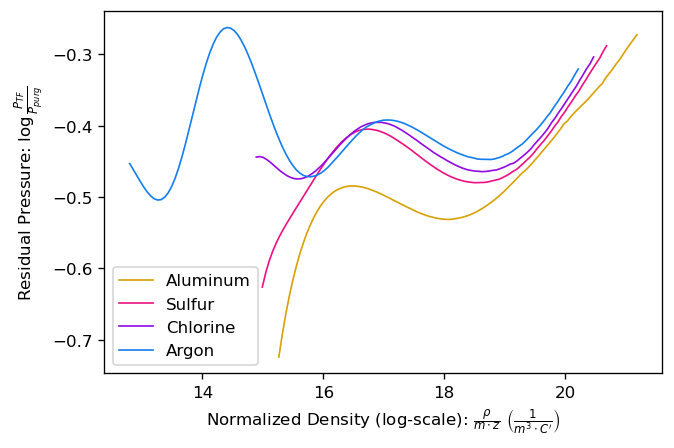

In [24]:
plt.figure(dpi=120)

ldv_displacement = {}
ldv, ldv_max, ldv_min = {}, {}, {}
for elem in orbital[(3, 'p')]:
    e, r = element[elem], residual[elem]

    x = r[:, 0] + 3 * np.log(e.atomic_radius_rahm) - np.log(e.mass)
    y = r[:, 1]
    l = np.diff(np.log(y)) / np.diff(x)
    ldv[elem] = np.array([r[:-1, 0], l]).T

    min_lo, min_hi, max_lo, max_hi = np.searchsorted(x, [16, 18, 17, 19])
    index = min_lo + np.argmax(l[min_lo:min_hi])
    ldv_max[elem] = (x[index], l[index])

    index = max_lo + np.argmin(l[max_lo:max_hi])
    ldv_min[elem] = (x[index], l[index])

    ldv_displacement[elem] = -(ldv_max[elem][0] + ldv_min[elem][0]) / 2

    if elem in noble_gases:
        plt.plot(x[100:-1], l[100:], color=color(e.mass, scale=24), linewidth=1, label=e.name)
    else:
        plt.plot(x[:-1], l, color=color(e.mass, scale=24), linewidth=1, label=e.name)

plt.xlabel(r"Normalized Density (log-scale): $\frac{\rho}{m \cdot z}$ $\left(\frac{1}{m^3 \cdot C'}\right)$")
plt.ylabel(r"Residual Pressure: $\log \frac{P_{TF}}{P_{purg}}$")

plt.legend()
plt.show()

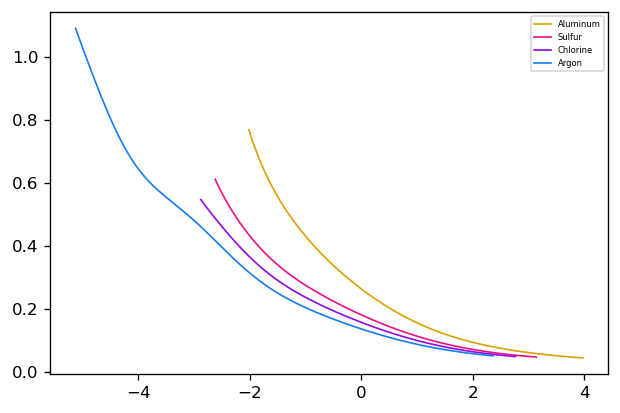

In [69]:
plt.figure(dpi=120)

for elem in orbital[(3, 'p')]:
    e, r, d = element[elem], residual[elem], ldv_displacement[elem]

    x = r[:, 0] + 3 * np.log(e.atomic_radius_rahm) - np.log(e.mass)
    y = r[:, 1]

    if elem in noble_gases:
        plt.plot(x[100:] + d, y[100:], color=color(e.mass, scale=24), linewidth=1, label=e.name)
    else:
        plt.plot(x + d, y, color=color(e.mass, scale=24), linewidth=1, label=e.name)

plt.legend(fontsize=5)
plt.show()

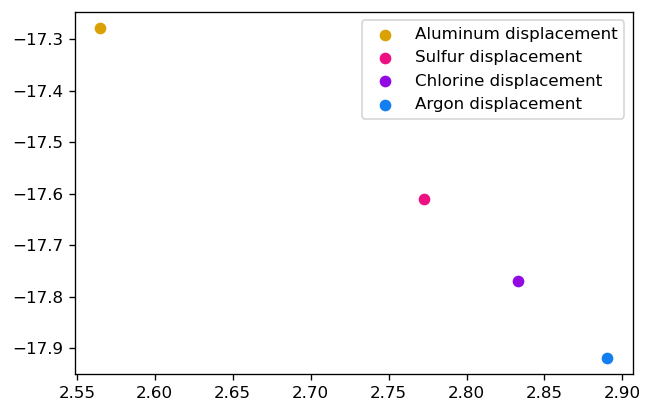

In [70]:
plt.figure(dpi=120)

for elem in orbital[(3, 'p')]:
    e, d = element[elem], ldv_displacement[elem]

    plt.scatter(np.log(e.atomic_number), d, color=color(e.mass, scale=24), label=e.name + ' displacement')

plt.legend()
plt.show()

## Orbital Analysis (2p)

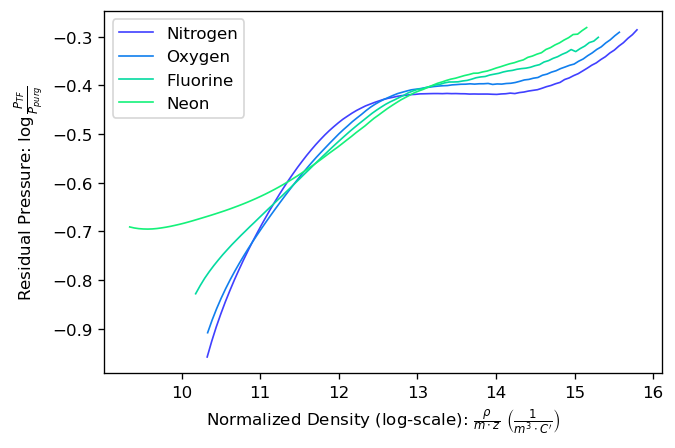

In [72]:
plt.figure(dpi=120)

for elem in orbital[(2, 'p')]:
    e, r = element[elem], residual[elem]

    x = r[:, 0] + 2 * np.log(e.atomic_radius_rahm) - np.log(e.mass)
    y = r[:, 1]
    l = np.diff(np.log(y)) / np.diff(x)
    ldv[elem] = np.array([r[:-1, 0], l]).T

    # min_lo, min_hi, max_lo, max_hi = np.searchsorted(x, [16, 18, 17, 19])
    # index = min_lo + np.argmax(l[min_lo:min_hi])
    # ldv_max[elem] = (x[index], l[index])

    # index = max_lo + np.argmin(l[max_lo:max_hi])
    # ldv_min[elem] = (x[index], l[index])

    # displacement[elem] = -(ldv_max[elem][0] + ldv_min[elem][0]) / 2

    if elem in noble_gases:
        plt.plot(x[150:-1], l[150:], color=color(e.mass, scale=24), linewidth=1, label=e.name)
    else:
        plt.plot(x[:-1], l, color=color(e.mass, scale=24), linewidth=1, label=e.name)

plt.xlabel(r"Normalized Density (log-scale): $\frac{\rho}{m \cdot z}$ $\left(\frac{1}{m^3 \cdot C'}\right)$")
plt.ylabel(r"Residual Pressure: $\log \frac{P_{TF}}{P_{purg}}$")

plt.legend()
plt.show()

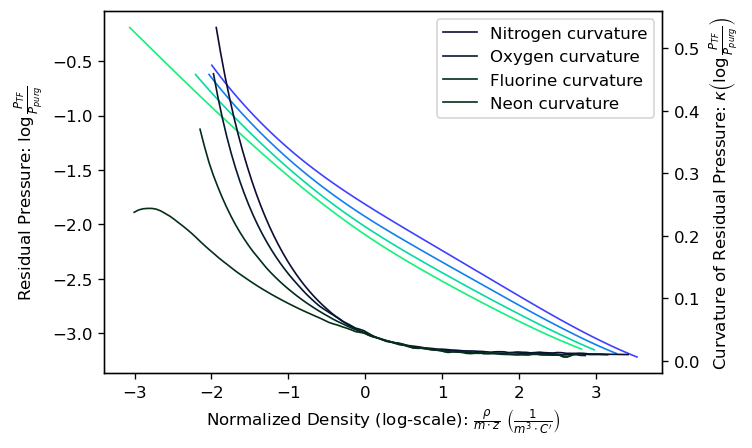

In [71]:
fig, residual_plt = plt.subplots()
curvature_plt = residual_plt.twinx()
fig.dpi = 120

curvature_log_max = {}
curvature_log = {}
for elem in orbital[(2, 'p')]:
    e, r = element[elem], residual[elem]

    x = r[:, 0] - np.log(e.mass * e.atomic_number)
    y = np.log(r[:, 1])

    dV = np.diff(r.T, axis=1)
    dV = (dV[:, :-1] + dV[:, 1:]) / 2
    dS = np.linalg.norm(dV, axis=0)
    T = dV / dS
    dT = np.diff(T, axis=1)
    c = np.linalg.norm(dT, axis=0) / dS[:-1]

    curvature_log[elem] = np.array([r[1:-2, 0], c]).T
    # curvature_list.append((e, np.array([r[1:-1, 0], curvature]).T))

    # lo, hi = np.searchsorted(x, [-8.75, -2.5])
    # curvature_log_max[elem] = x[lo + np.argmax(c[lo:hi]) + 1]

    if elem in noble_gases:
        residual_plt.plot(x[150:], y[150:], color=color(e.mass, scale=24), linewidth=1, label=e.name)
        curvature_plt.plot(x[151:-2], c[150:], color=0.2 * color(e.mass, scale=24), linewidth=1, label=e.name + ' curvature')
    else:
        residual_plt.plot(x, y, color=color(e.mass, scale=24), linewidth=1, label=e.name)
        curvature_plt.plot(x[1:-2], c, color=0.2 * color(e.mass, scale=24), linewidth=1, label=e.name + ' curvature')

residual_plt.set_xlabel(r"Normalized Density (log-scale): $\frac{\rho}{m \cdot z}$ $\left(\frac{1}{m^3 \cdot C'}\right)$")
residual_plt.set_ylabel(r"Residual Pressure: $\log \frac{P_{TF}}{P_{purg}}$")
curvature_plt.set_ylabel(r"Curvature of Residual Pressure: $\kappa\left(\log \frac{P_{TF}}{P_{purg}}\right)$")

curvature_plt.legend()
plt.show()

## Orbital Analysis (3d)

To extract the proposed form, we take the logarithm, demean and use Principal Component Analysis.

PCA Accuracy: 0.995526085363098
[4.29099672 4.14761904 4.28928212 4.07464963 4.02040392]


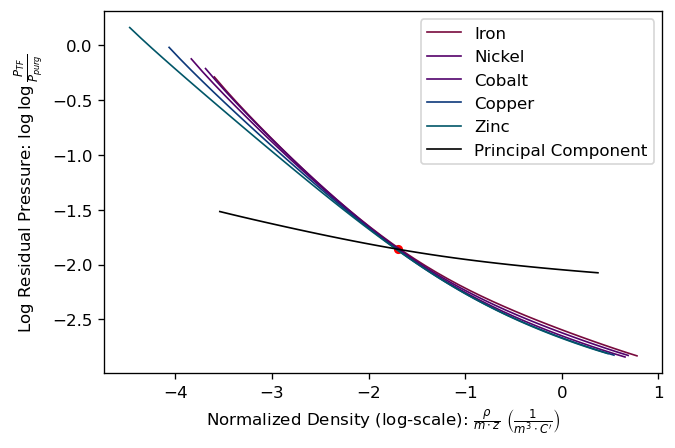

In [18]:
plt.figure(dpi=120)

x_min, x_max = -np.inf, np.inf
for e, r in target_orbital:
    x = r[:, 0] - np.log(e.mass * e.atomic_number)
    x_min, x_max = max(x_min, x[0]), min(x_max, x[-1])

num_points = np.inf
lo_list = []
for e, r in target_orbital:
    lo, hi = np.searchsorted(r[:, 0] - np.log(e.mass * e.atomic_number), [x_min, x_max])
    lo_list.append((e, lo))
    num_points = min(num_points, hi - lo)

xM, yM = [], []
for e, r in target_orbital:
    x = r[:, 0] - np.log(e.mass * e.atomic_number)
    y = np.log(r[:, 1])
    lo = np.searchsorted(x, x_min)

    xM.append(x[lo:lo + num_points])
    yM.append(y[lo:lo + num_points])

    plt.plot(x, y, color=0.2 * color(e.mass, scale=24), linewidth=1, label=e.name)

xM = np.array(xM)
yM = np.array(yM)
x = np.mean(xM, axis=0)

index = np.argmin(np.ptp(yM, axis=0))
x_intersection, y_intersection = np.mean(xM[:, index]), np.mean(yM[:, index])
plt.scatter(x_intersection, y_intersection, s=20, color='red')

U, S, VT = np.linalg.svd(yM - y_intersection)
print(f'PCA Accuracy: {(S[0] / np.linalg.norm(S)) ** 2}')
pc = -VT[0]
coefficients = (yM - y_intersection) @ pc
print(coefficients)

plt.plot(x, pc + y_intersection, color='black', linewidth=1, label='Principal Component')

plt.xlabel(r"Normalized Density (log-scale): $\frac{\rho}{m \cdot z}$ $\left(\frac{1}{m^3 \cdot C'}\right)$")
plt.ylabel(r"Log Residual Pressure: $\log\log \frac{P_{TF}}{P_{purg}}$")

plt.legend()
plt.show()